In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helperslib import generate_dummies, convert_category_text_to_number

In [2]:
%matplotlib inline


# Работа с данными

## Описание переменных
| Название | Тип данных | Описание |
| ----------- | ----------- | ----------- |
| recency | quantity | месяцы с момента последней покупки |
| history | quantity | стоимость прошлых покупок | 
| used_discount | category | использовал ли клиент скидку ранее | 
| used_bogo | category | использовал ли покупку раньше | 
| zip_code | category | класс местности Пригородный/Городской/Сельский (Suburban/Urban/Rural) | 
| is_referral | category | был ли клиент приобретен через реферальный канал | 
| channel | category | канал который использует покупатель Телефон/Интернет/Многоканальный (Phone/Web/Multichannel) | 
| offer | treatment | предложения, отправленные клиентам, Скидка/Купить Один, Получить один/Нет предложения (Discount/But One Get One/No Offer) | 
| conversion | target | конвертация клиентов(покупать или нет) | 


In [3]:
CLIENTS_PATH = 'data.csv'
TARGET = 'Credit Default'

TREATMENT_NAME = 'treatment'
TARGET_NAME = 'target'

SELECTED_FEATURE_NAMES= ['recency', 
                         'history',
                         'used_discount',
                         'used_bogo',
                         #'zip_code',           # класс местности Пригородный/Городской/Сельский
                         'zip_code__cat',
                         'is_referral',
                         #'channel'             # канал который использует покупатель Телефон/Интернет/Многоканальный
                         'channel__cat'
                        ]

cat_features = ['used_discount',    # использование дискаунта раньше
                'used_bogo',        # использовал ли покупку раньше
                'zip_code__cat',         # класс местности Пригородный/Городской/Сельский
                'is_referral',      # был ли клиент приобретен через реферальный канал
                'channel__cat'           # канал который использует покупатель Телефон/Интернет/Многоканальный
]

# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

## Загрузка и обработка данных

### Загрузка данных

In [4]:
# загрузка набора данных маркетинговых кампаний
df_clients = pd.read_csv(CLIENTS_PATH)

### Обработка данных

In [5]:
# переименовать поля
df_clients = df_clients.rename(columns={
    #'offer':TREATMENT_NAME, 
    'conversion':TARGET_NAME})

In [6]:
# приводим поле treatment к бинарному виду
# df_clients[TREATMENT_NAME] = df_clients[TREATMENT_NAME].map({'No Offer':False}).astype(bool)
df_clients[TREATMENT_NAME] = df_clients['offer'].apply(lambda x: 0 if 'No Offer' in x else 1).astype(int)
df_clients[TREATMENT_NAME].value_counts()


1    42694
0    21306
Name: treatment, dtype: int64

In [7]:
# настройка категориальных признаков если такие имеются
df_clients['zip_code__cat'] = convert_category_text_to_number(df_clients, 'zip_code')
df_clients['channel__cat'] = convert_category_text_to_number(df_clients, 'channel')

<< zip_code >>
Index: Value:    
0       Rural     
1       Surburban 
2       Urban     
----------
<< channel >>
Index: Value:    
0       Multichannel
1       Phone     
2       Web       
----------


### Разбиваем данные

In [8]:
df_clients_train, df_clients_valid = train_test_split(df_clients, test_size=0.30, random_state=21)

# Моделирование

### Формируем таблицы данных для обучения

In [9]:
# признаки о клиенте
X_train = df_clients_train[SELECTED_FEATURE_NAMES]
X_valid = df_clients_valid[SELECTED_FEATURE_NAMES]

# целевой признак
y_train = df_clients_train[TARGET_NAME]
y_valid = df_clients_valid[TARGET_NAME]

# те на кого была произведена маркетинговая кампания 
treat_train = df_clients_train[TREATMENT_NAME]
treat_valid = df_clients_valid[TREATMENT_NAME]

## Uplift-моделирование S learner

In [10]:
# провести uplift-моделирование 3 способами: 
# одна модель с признаком коммуникации (S learner), 
# модель с трансформацией таргета (трансформация классов п. 2. 1) 
# вариант с двумя независимыми моделями

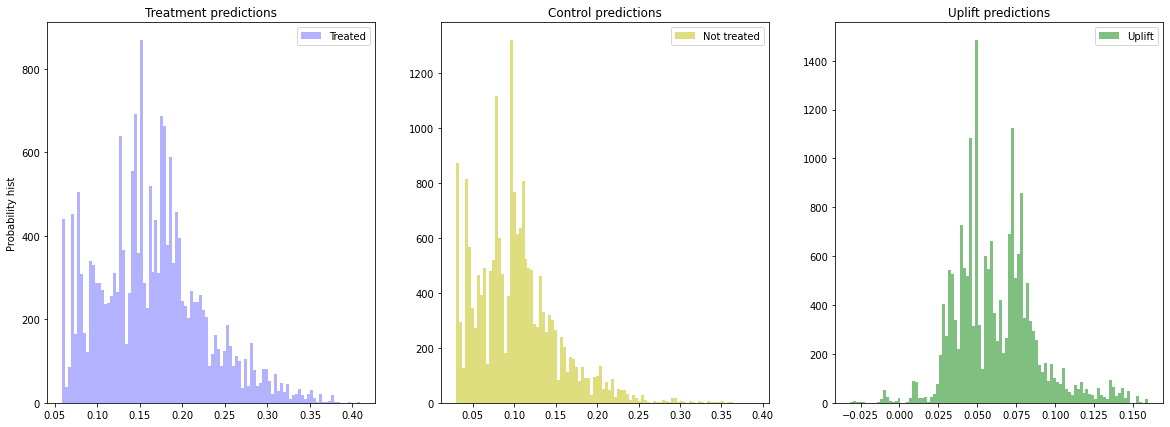

In [11]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# воспользуемся catboost
from catboost import CatBoostClassifier

N =20000
sm = SoloModel(  CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(  X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)
sm_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(   sm.trmnt_preds_ , sm.ctrl_preds_, bins=100);

In [12]:
# топ признаки
pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,treatment,21.907619
1,is_referral,20.888463
2,used_bogo,12.325199
3,zip_code__cat,11.518851
4,recency,10.804377
5,used_discount,8.397037
6,history,8.193585
7,channel__cat,5.964868


In [13]:
# таблица по процентилям
from sklift.metrics import uplift_by_percentile


uplift_by_percentile(y_valid, uplift_sm, treat_valid, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1278,642,0.269953,0.155763,0.114190,0.012418,0.014312,0.018948
10-20,1295,625,0.198456,0.128000,0.070456,0.011083,0.013364,0.017361
20-30,1292,628,0.186533,0.127389,0.059144,0.010837,0.013304,0.017160
30-40,1284,636,0.169003,0.138365,0.030638,0.010458,0.013691,0.017229
40-50,1311,609,0.168574,0.144499,0.024074,0.010340,0.014247,0.017604
50-60,1293,627,0.175561,0.100478,0.075082,0.010580,0.012006,0.016003
60-70,1260,660,0.139683,0.078788,0.060895,0.009766,0.010487,0.014330
70-80,1279,641,0.135262,0.095164,0.040098,0.009563,0.011590,0.015026
80-90,1297,623,0.114880,0.080257,0.034624,0.008854,0.010885,0.014031


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0543'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

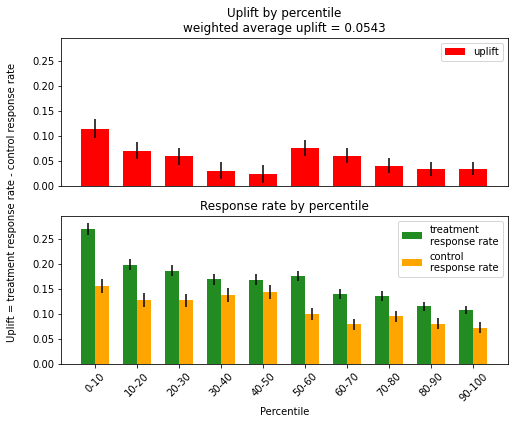

In [14]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_sm, treat_valid, 
                          strategy='overall', kind='bar');


## Модель с трансформацией таргета

In [15]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_valid)

ct_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)


<ipython-input-15-9050a9eb14c8>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


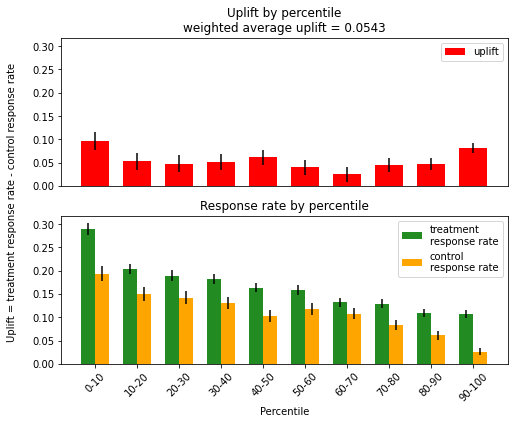

In [16]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_ct, treat_valid, 
                          strategy='overall', kind='bar');

## Вариант с двумя независимыми моделями

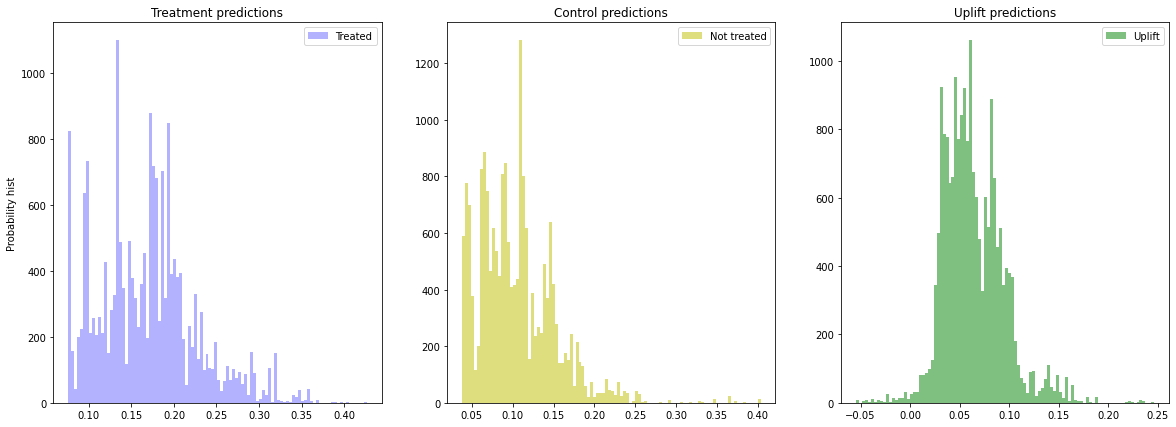

In [17]:
from sklift.models import TwoModels


tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_valid)

tm_score10 = uplift_at_k( y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k( y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

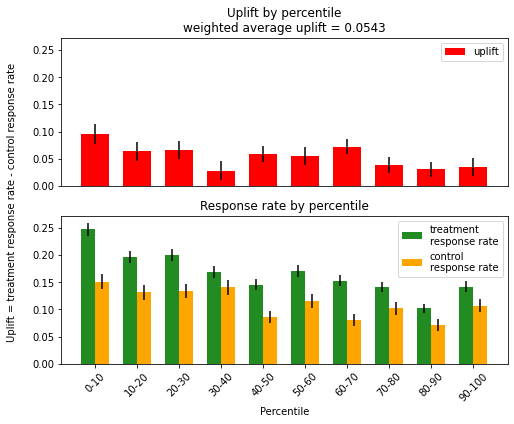

In [18]:
# график по процентилям
from sklift.viz import plot_uplift_by_percentile


plot_uplift_by_percentile(y_valid, uplift_tm, treat_valid, strategy='overall', kind='bar');

In [19]:
# Сравнение трех моделей по результатам метрик
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.113925,0.091932
1,ClassTransformation,0.095964,0.073746
2,TwoModels,0.095478,0.078735


## Модель с деревом решений


### Формируем таблицы данных для обучения деревом решений

In [20]:
SELECTED_FEATURE_NAMES_TREE = [
    'recency', 
    'history',
    'used_discount',
    'used_bogo',
    'zip_code',           
    'is_referral',
    'channel'    
]

X_train_tree_raw = df_clients_train[SELECTED_FEATURE_NAMES_TREE]
X_valid_tree_raw = df_clients_valid[SELECTED_FEATURE_NAMES_TREE]

In [21]:
# Добавляем dummy столбцы
CAT_FEATURES_TREE_DUMMIES = [
                'zip_code',
                'channel'  
]

X_train_tree = generate_dummies(X_train_tree_raw, CAT_FEATURES_TREE_DUMMIES)
X_valid_tree = generate_dummies(X_valid_tree_raw, CAT_FEATURES_TREE_DUMMIES)
features = [col for col in X_train_tree]

### Обучение

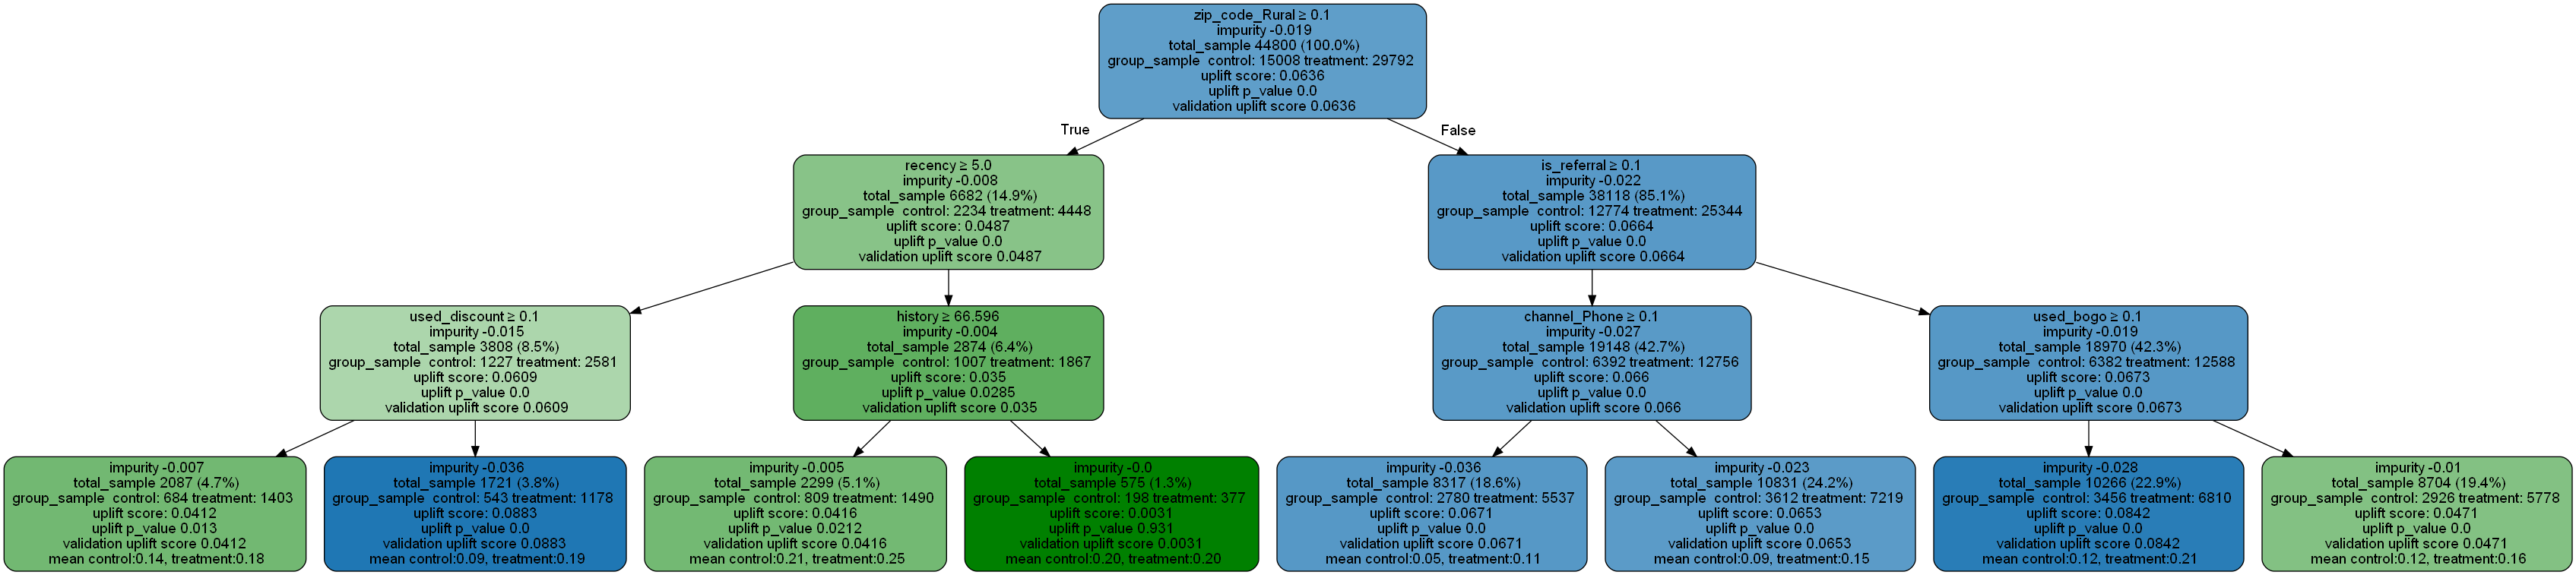

In [22]:
# модель с деревом решений
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

display(Image(graph.create_png()))

### Описание дерева
Потециальным клиентом является: 
---
	1.1 Житель сельской местности 
	1.2 Совершивший последнюю покупку более 5 месяцев назад
	1.3 Не использовавший ранее скидок
	1.4 Отреагирует на маркетинговую кампанию (С вероятностью (так и не нашел где увидить вероятность) воспользуется предложением банка)
---
	2.1 Житель не сельской местности 
	2.2 Не приобретенный через реферальный канал
	2.3 Использовавший покупку раньше
	2.4 Отреагирует на маркетинговую кампанию (С вероятностью (так и не нашел где увидить вероятность) воспользуется предложением банка)